<h1 align="center">Rossmann Store Sales Prediction Report</h1>
<h3 align="right"> By Derbew Felasman <h3>

## Objective
The primary objective of this project is to predict daily sales in various stores up to six weeks in advance. This forecasting allows the company to plan ahead and make informed business decisions.

## Dataset

- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- sample_submission.csv - a sample submission file in the correct format
- store.csv - supplemental information about the stores

The dataset comprises various fields, each providing valuable insights into sales patterns. Key features include:

- Id: A unique identifier for each (Store, Date) pair in the test set.
- Store: A unique ID for each store.
- Sales: The turnover for any given day, which is the target variable we aim to predict.
- Customers: The number of customers on a given day.
- Open: An indicator for whether the store was open: 0 = closed, 1 = open.
- StateHoliday: Indicates a state holiday, with 'a' representing public holidays, 'b' representing Easter holidays, 'c' representing Christmas, and '0' representing no holiday.
- SchoolHoliday: Indicates if the (Store, Date) was affected by the closure of public schools.
- StoreType: Differentiates between four different store models: a, b, c, and d.
- Assortment: Describes an assortment level: a = basic, b = extra, c = extended.
- CompetitionDistance: The distance in meters to the nearest competitor store.
- CompetitionOpenSince[Month/Year]: The approximate year and month of the time the nearest competitor was opened.
- Promo: Indicates whether a store is running a promo on that day.
- Promo2: A continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.
- Promo2Since[Year/Week]: Describes the year and calendar week when the store started participating in Promo2.
- PromoInterval: Describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import pickle
import logging
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from prophet import Prophet
import os, sys

/home/derbew/Documents/10a/Rossmann_Store_Sales_Analysis/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")

In [2]:
# Get the absolute path to the parent directory
parent_dir = os.path.dirname(os.getcwd())

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from src import handler, visualizer

## Exploratory Data Analysis (EDA)
Key Steps:

- Data Cleaning: Handling missing values and ensuring data integrity.
- Feature Engineering: Extracting features from date columns, such as day of the week, weekends, holidays, and month segments.
- Visualization: Creating plots to visualize sales trends, seasonality, and other patterns.

Insights:

- Identified significant sales patterns related to weekdays, weekends, and holidays.
- Noted seasonality in sales data corresponding to different times of the month and year.



### Data Gathering

In [4]:
def load_data(path):
    try:
        df = pd.read_csv(path, low_memory=False)
        return df
    except Exception as e:
        print(f"Error on Loding Data {e}")

In [6]:
path1 = "../data/01_raw/train.csv"
path2 = "../data/01_raw/store.csv"
path3 = "../data/01_raw/test.csv"
train_df =load_data(path1)
test_df = load_data(path3)
store_df = load_data(path2)

In [7]:
# merge the data set
train_df = pd.merge(train_df, store_df, how="inner", on="Store")
test_df = pd.merge(test_df, store_df, how="inner", on="Store")

In [8]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


### Data Cleaning

In [11]:
# create handler object
handler_df1 = handler.Handler(train_df)
handler_df2 = handler.Handler(test_df)

In [13]:
# check missing values train_df
handler_df1.calculate_missing_percentage()

                           Missing Values Percentage Missing
Store                                   0              0.00%
DayOfWeek                               0              0.00%
Date                                    0              0.00%
Sales                                   0              0.00%
Customers                               0              0.00%
Open                                    0              0.00%
Promo                                   0              0.00%
StateHoliday                            0              0.00%
SchoolHoliday                           0              0.00%
StoreType                               0              0.00%
Assortment                              0              0.00%
CompetitionDistance                  2642              0.26%
CompetitionOpenSinceMonth          323348             31.79%
CompetitionOpenSinceYear           323348             31.79%
Promo2                                  0              0.00%
Promo2SinceWeek         

In [15]:
def fill_missing_value(df, col):
    try:
        if df[col].dtype == "object":
            df[col] = df[col].fillna(df[col].mode()[0])
            return df
        df[col] = df[col].fillna(df[col].median())
        return df
    except Exception as e:
        print(f"ERROR {e}")

In [16]:
# Fill missing value
# column with missing value
cols = ["CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]
for col in cols:
    train_df = fill_missing_value(train_df, col)
    test_df = fill_missing_value(test_df, col)

In [17]:
# check missing values train_df
handler_df1.calculate_missing_percentage()

                           Missing Values Percentage Missing
Store                                   0              0.00%
DayOfWeek                               0              0.00%
Date                                    0              0.00%
Sales                                   0              0.00%
Customers                               0              0.00%
Open                                    0              0.00%
Promo                                   0              0.00%
StateHoliday                            0              0.00%
SchoolHoliday                           0              0.00%
StoreType                               0              0.00%
Assortment                              0              0.00%
CompetitionDistance                     0              0.00%
CompetitionOpenSinceMonth               0              0.00%
CompetitionOpenSinceYear                0              0.00%
Promo2                                  0              0.00%
Promo2SinceWeek         

In [18]:
#check duplicate values for train_df
handler_df1.check_duplicate()


Duplicated values:
0 duplicated rows


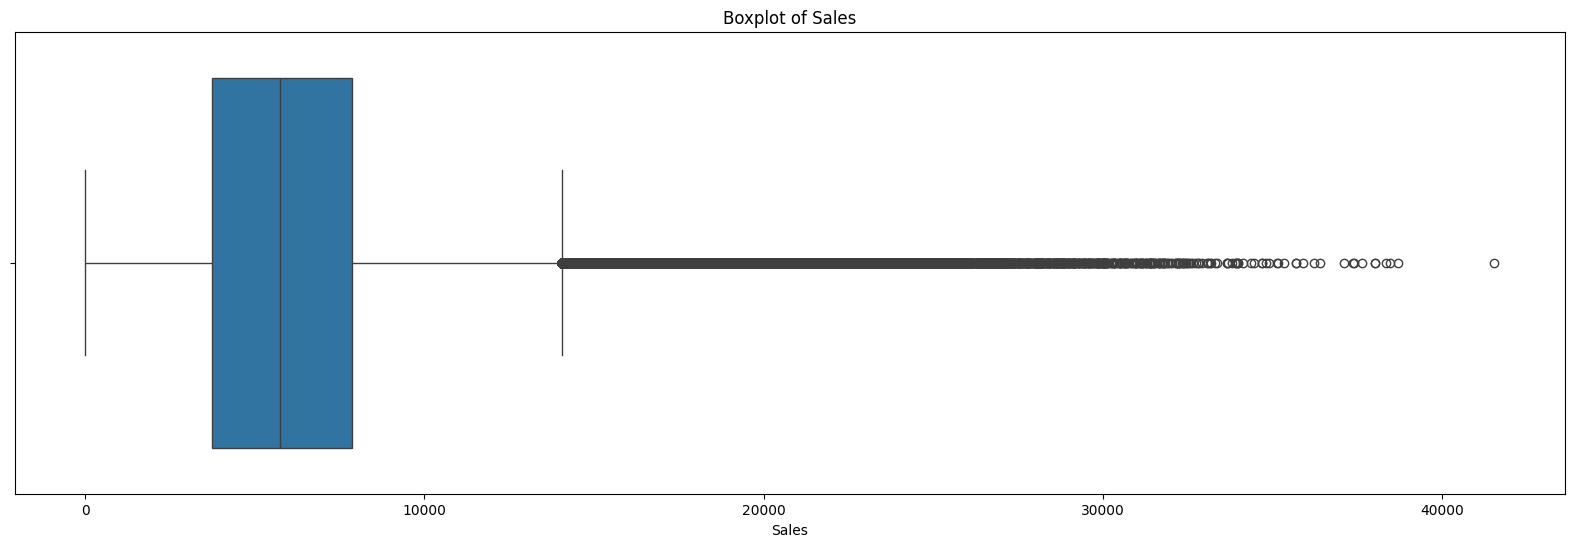

In [19]:
# Identifying outliers
visualizer.plot_boxplot(train_df, "Sales")

In [20]:
#removing Outliers
train_df=handler_df1.remove_iqr_outliers("Sales")

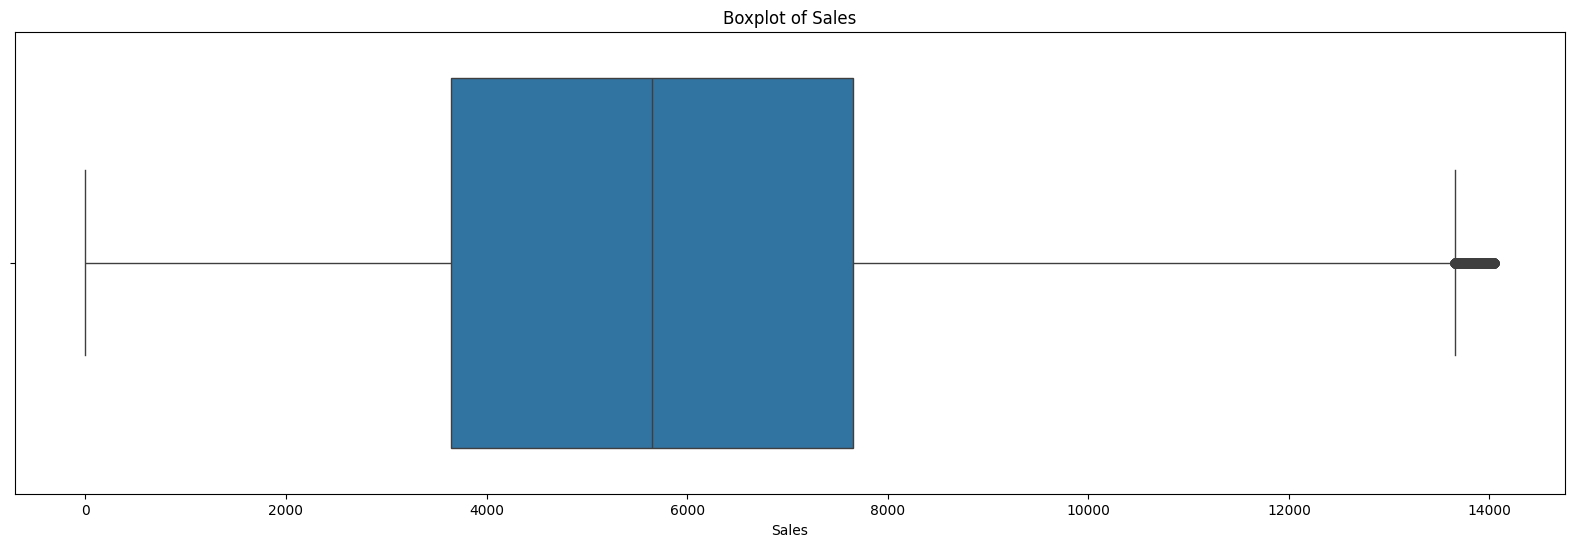

In [21]:
visualizer.plot_boxplot(train_df, "Sales")

#### Feature selection and Feature Engineering

In [22]:
train_df = handler_df1.create_date_features()
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Week,Month,Year,Season
0,1,5,2015-07-31,5263.0,555,1,1,0,1,c,...,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
1,2,5,2015-07-31,6064.0,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
2,3,5,2015-07-31,8314.0,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
3,4,5,2015-07-31,13995.0,1498,1,1,0,1,c,...,2009.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer
4,5,5,2015-07-31,4822.0,559,1,1,0,1,a,...,2015.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct",31,31,7,2015,Summer


### Descriptive Statistics

In [23]:
num_col, cat_col = train_df.select_dtypes(exclude=['object']), train_df.select_dtypes(include=["object"])

In [24]:
# stats for numric type
num_col.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Day,Week,Month,Year
count,1.017209e+06,1.017209e+06,1017209,990515.000000,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209.0,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5465.548842,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.422034e+03,7.469899e+00,2.009107e+03,5.005638e-01,2.263526e+01,2.011876e+03,1.570279e+01,23.615515,5.846762e+00,2.013832e+03
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,1.000000e+00,2.009000e+03,1.000000e+00,1.0,1.000000e+00,2.013000e+03
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3650.000000,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,6.000000e+00,2.008000e+03,0.000000e+00,2.200000e+01,2.012000e+03,8.000000e+00,11.0,3.000000e+00,2.013000e+03
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5651.000000,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.330000e+03,8.000000e+00,2.010000e+03,1.000000e+00,2.200000e+01,2.012000e+03,1.600000e+01,22.0,6.000000e+00,2.014000e+03
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7651.000000,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03,2.300000e+01,35.0,8.000000e+00,2.014000e+03
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,14049.000000,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03,3.100000e+01,52.0,1.200000e+01,2.015000e+03
std,3.219087e+02,1.997391e+00,NaN,3368.179566,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.706913e+03,2.677243e+00,4.986802e+00,4.999999e-01,9.993137e+00,1.182965e+00,8.787638e+00,14.433381,3.326097e+00,7.773960e-01


In [25]:
#stats for Categorical column
cat_col.describe()

,StateHoliday,StoreType,Assortment,PromoInterval,Season
count,1017209,1017209,1017209,1017209,1017209
unique,4,4,3,3,4
top,0,a,a,"Jan,Apr,Jul,Oct",Spring
freq,986159,551627,537445,801153,307740


## Univariate analysis
In univariate analysis, where only one variable is considered at a time. These visualizations help to understand the central tendency, spread, and shape of the distribution of a single variable.

#### What is the distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [26]:
# pie Plot
def plot_pie(df, col):
        counts = df[col].value_counts()

        # Create an explode sequence of zeros with the same length as promo_counts
        explode = [0]*len(counts)

        # Plot the pie chart
        plt.pie(counts, 
                labels=counts.index, 
                startangle=90, 
                counterclock=False, 
                autopct='%1.2f%%', 
                explode=explode, 
                shadow=True)
        plt.title(f'{col} Count Comparison', fontsize=15)
        plt.axis('equal')
        plt.show()

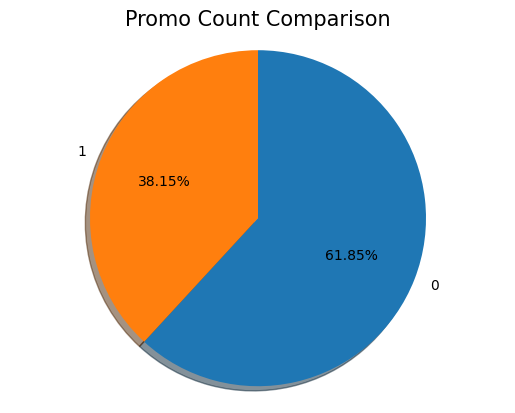

In [27]:
plot_pie(train_df, "Promo")

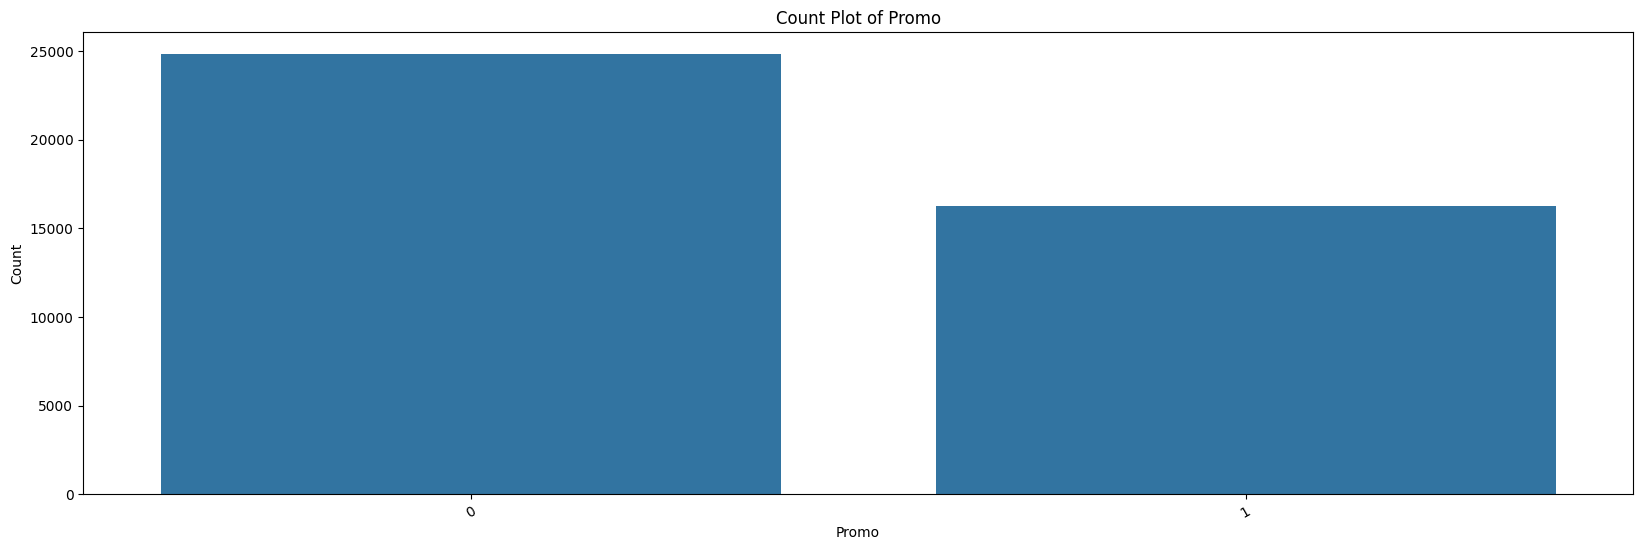

In [28]:
visualizer.plot_count(test_df, 'Promo')

Based on the plots, the `Promo` data distributions seems the same on both datasets.Based on the pie plot 61.85% of the stors are not participated in any promotions, and 38.15% of the stors are partcipated in Promotions.

## Bivariate analysis and Multivariate analysis

Multivariate analysis involves the study of three or more variables simultaneously. Visualizations for multivariate data can be more complex.

Bivariate analysis examines the relationship between two variables.

#### Find out any seasonal (Christmas, Easter, etc) purchase behaviors,


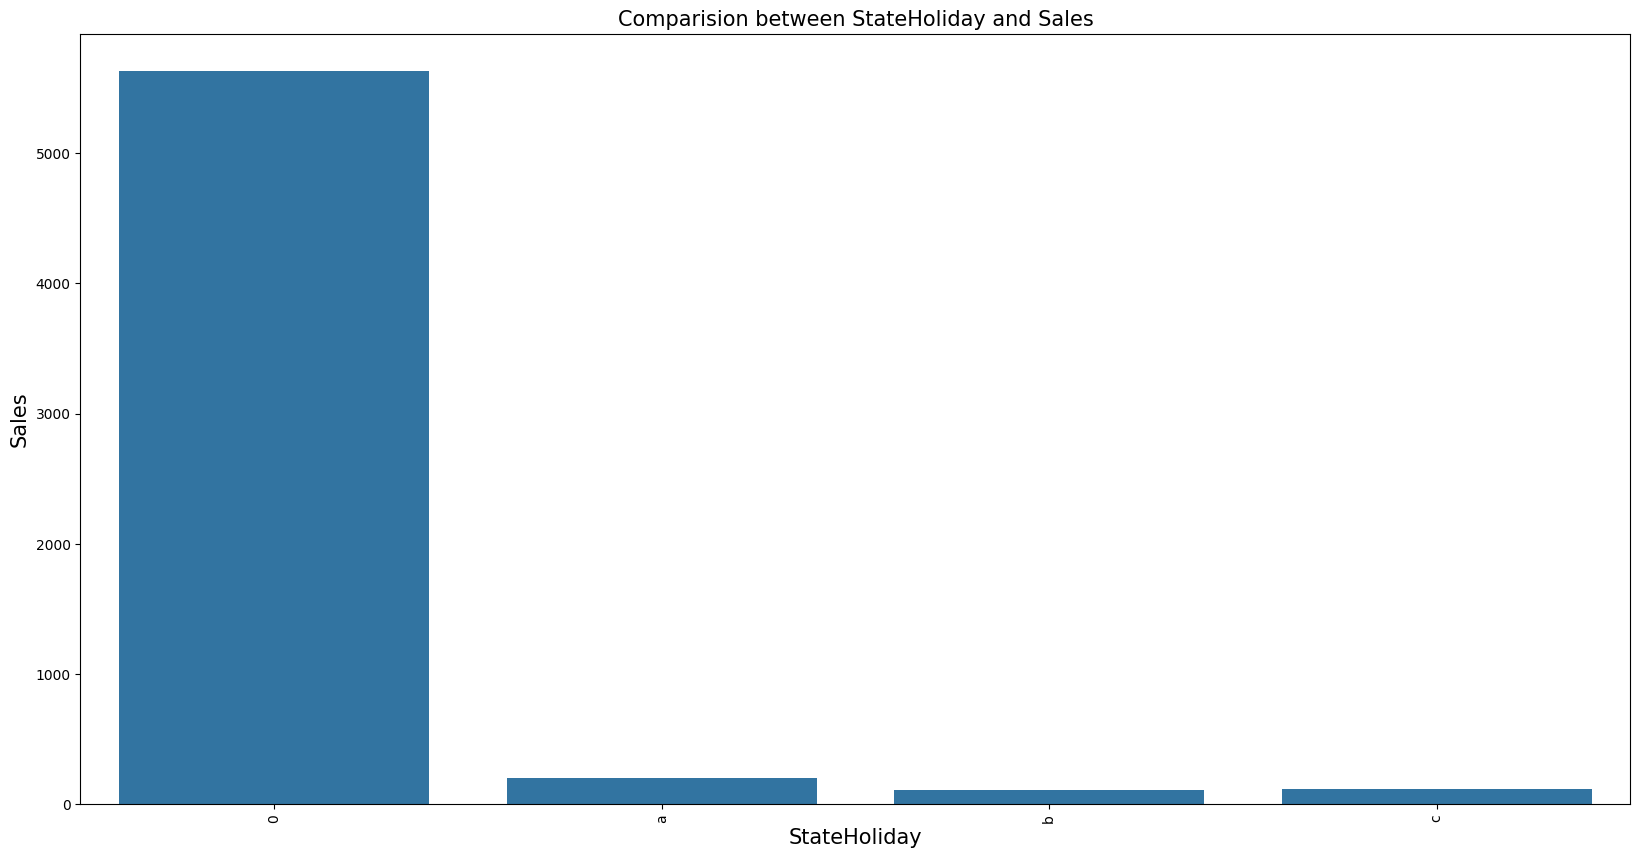

In [31]:
seasonal = train_df.groupby('StateHoliday')['Sales'].mean().reset_index()
plot_bar(seasonal, 'StateHoliday', 'Sales')

In the above plot, `a` representing public holidays, `b` representing Easter holidays, `c` representing Christmas, and `0` representing no holiday. 

Based on the plot, the sale is much better when there is no holiday.

#### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

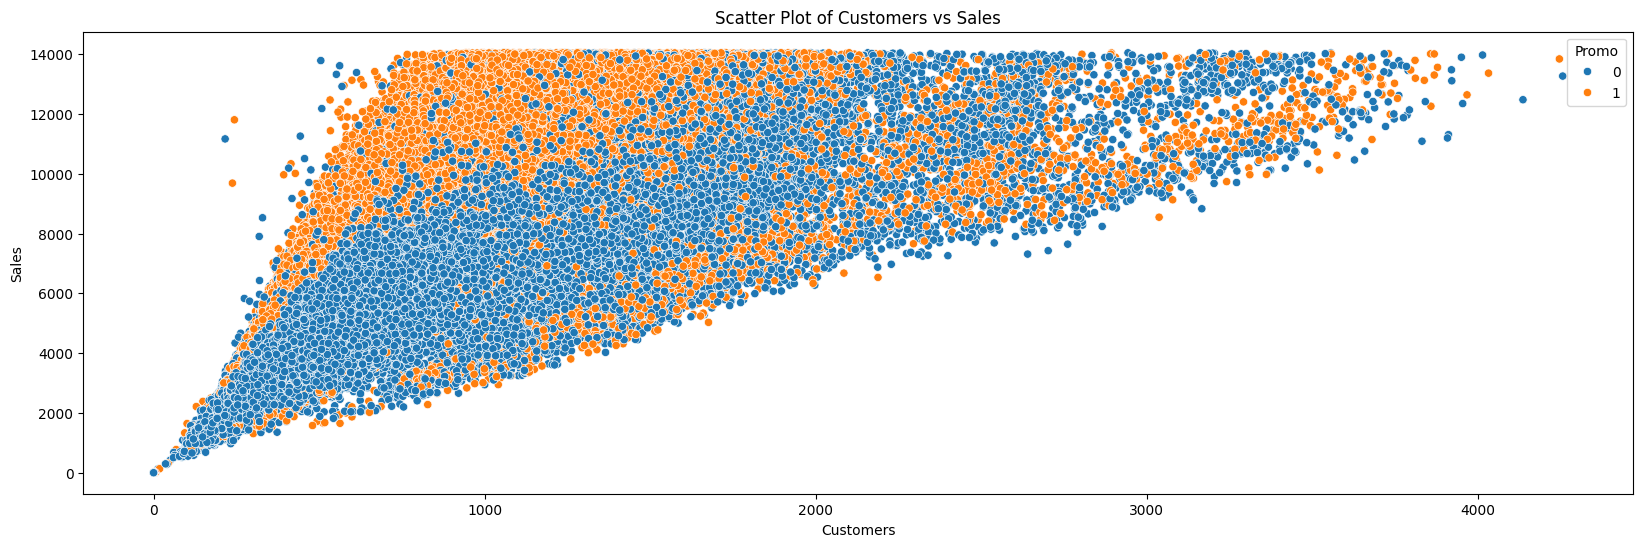

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [32]:
visualizer.plot_scatter(train_df, 'Customers', 'Sales', hue_col='Promo')

The plot shows, There is a postive correlation between `Sales` and `Customers`.

Average sales with promo: 7512.835578338434
Average sales without promo: 4250.614772321443
Difference in average sales: 3262.2208060169914
Average customers with promo: 751.3627649031864
Average customers without promo: 472.5710939670813
Difference in average customers: 278.7916709361051

#### Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

In [33]:
# Analyze Sales and Customers by Store
store_sales = train_df.groupby(['StoreType', 'Promo'])['Sales'].mean().reset_index()
store_customers = train_df.groupby(['StoreType', 'Promo'])['Customers'].mean().reset_index()

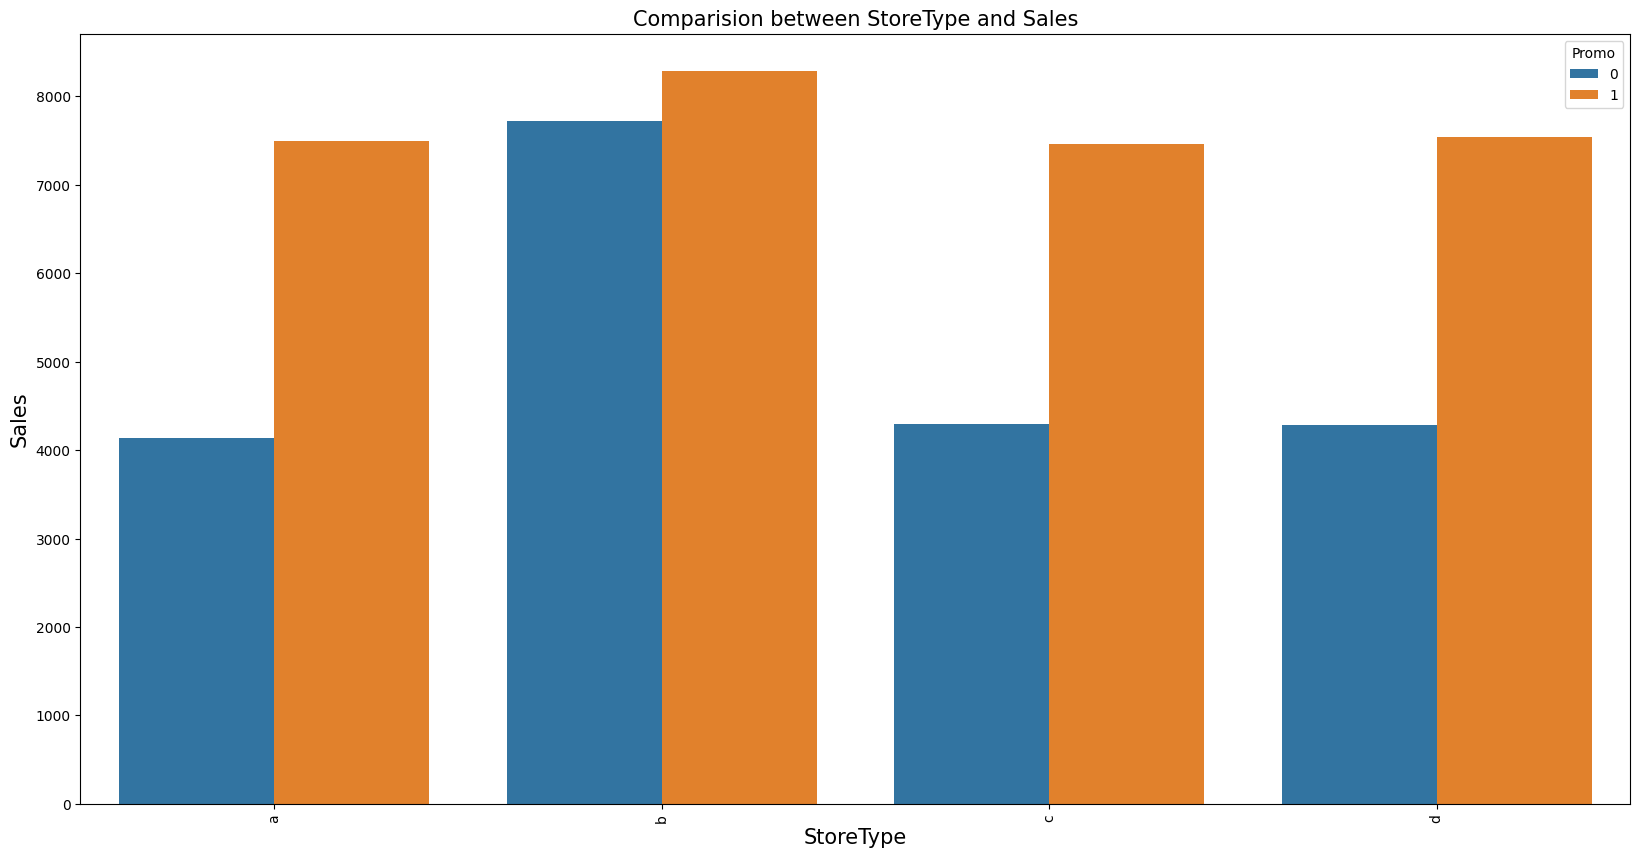

In [34]:
plot_bar(store_sales, 'StoreType', 'Sales', hue='Promo')

The above two plots show that stores with promotions had more sales and customers compared to stores with no promotions.

#### Which stores are open on all weekdays? How does that affect their sales on weekends?

In [35]:
# Filter the Data
open_stores = train_df[train_df['Open'] == 1]

# Group the Data
open_stores = open_stores.groupby(['DayOfWeek'])['Sales'].mean().reset_index()

# Analyze Sales on Weekends
weekend_sales_all_weekdays = open_stores[open_stores['DayOfWeek'].isin(list(range(1, 6)))]['Sales'].mean()
weekend_sales_all_stores = open_stores[open_stores['DayOfWeek'].isin([6, 7])]['Sales'].mean()

print(f"Average sales on weekends for stores open on all weekdays: {weekend_sales_all_weekdays}")
print(f"Average sales on weekends for all stores: {weekend_sales_all_stores}")

Average sales on weekends for stores open on all weekdays: 6829.925385347497
Average sales on weekends for all stores: 5950.292734346731


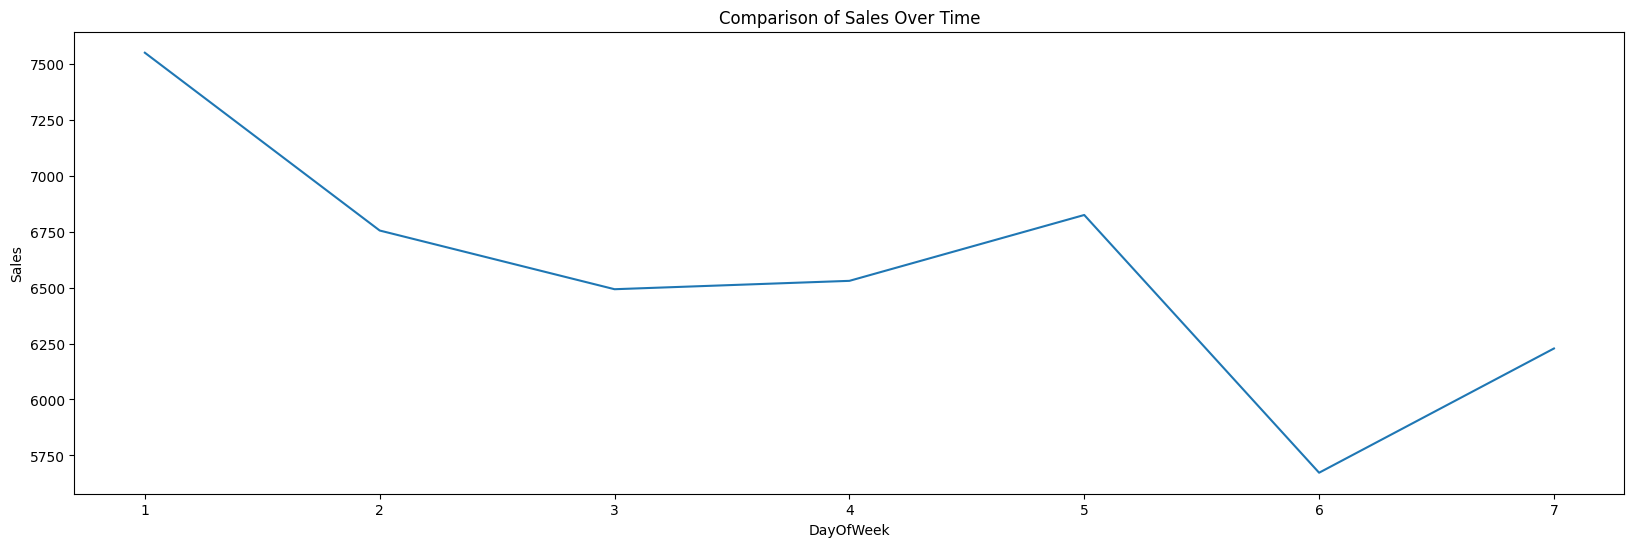

In [36]:
visualizer.plot_line(open_stores, 'DayOfWeek', 'Sales')

The line plot shows, On Monday the sales are higher, but they decrease on Tuesday. From Tuesday to Thursday, sales seem consistent. Sales increase again on Friday. However, on Saturday, sales are too low, and they increase once more on Sunday. In general, during the weekdays, sales are higher, whereas during the weekends, sales are smaller.

#### Trends over different Times.

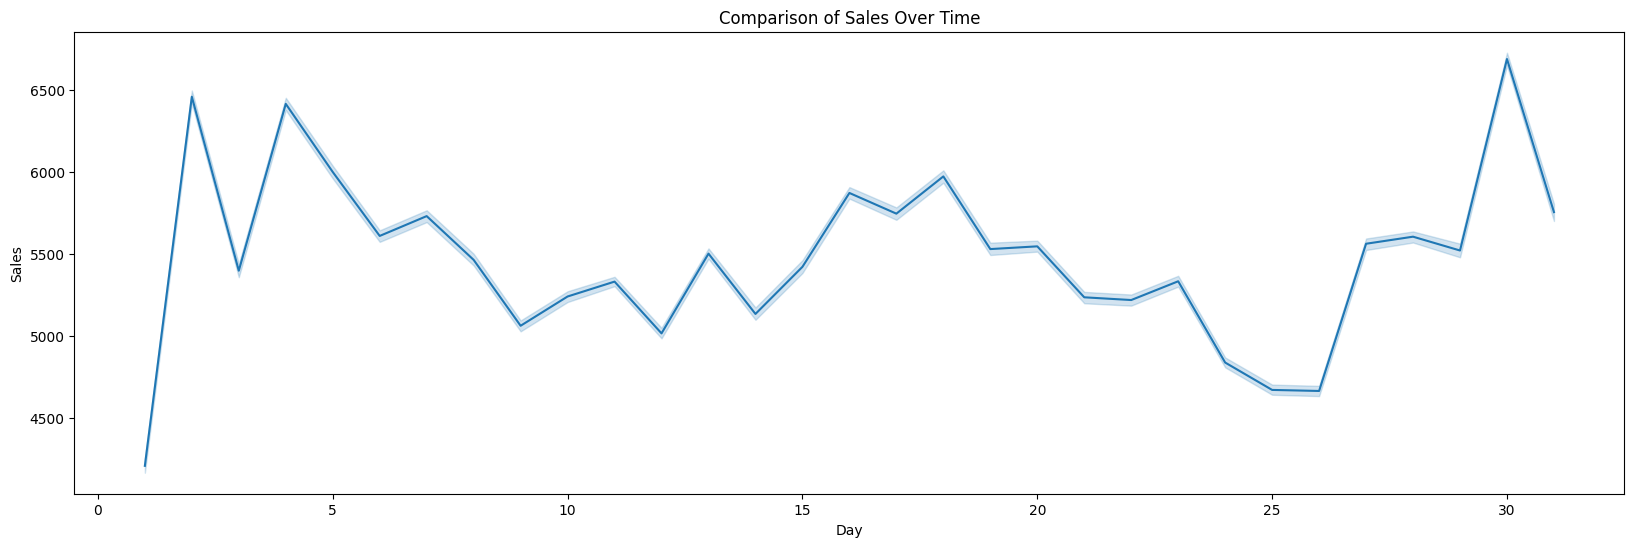

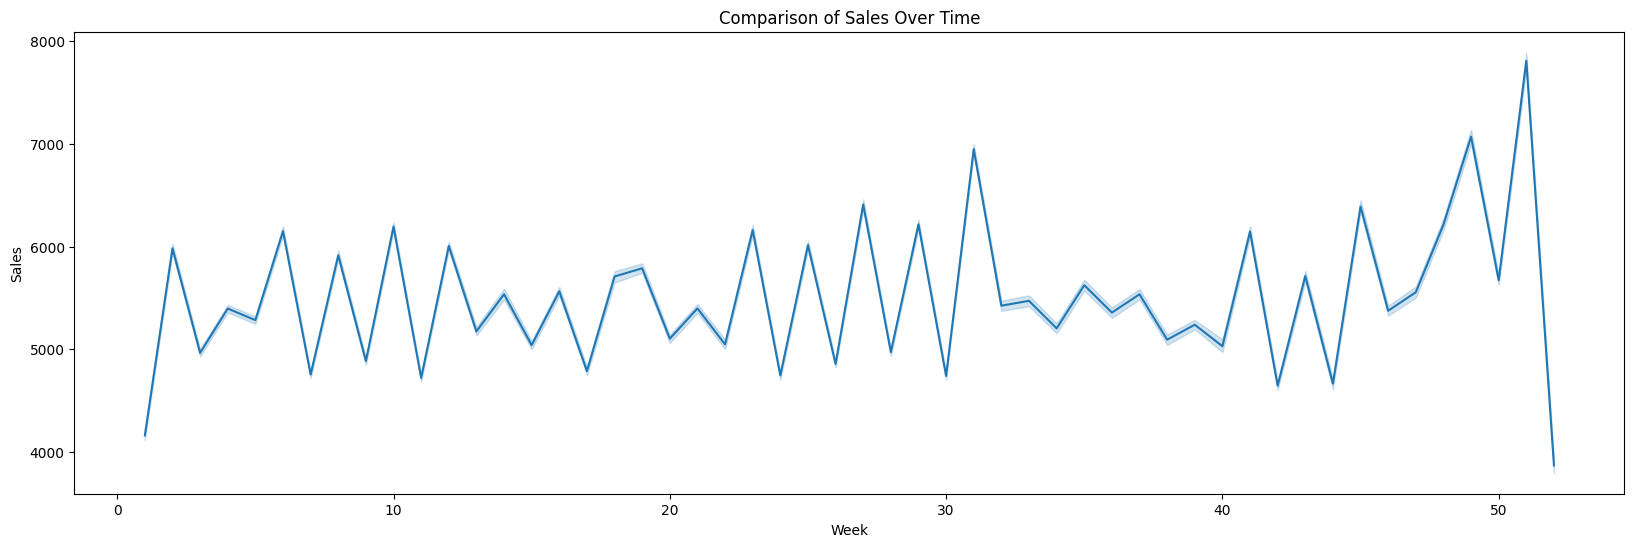

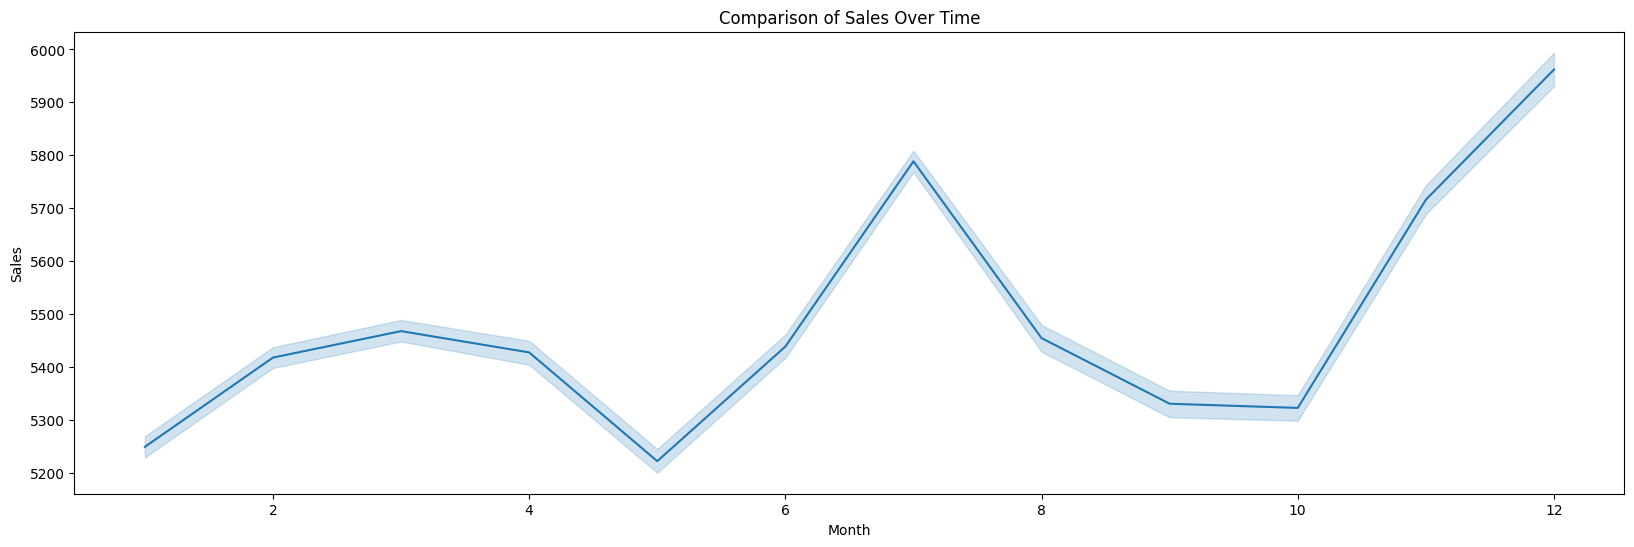

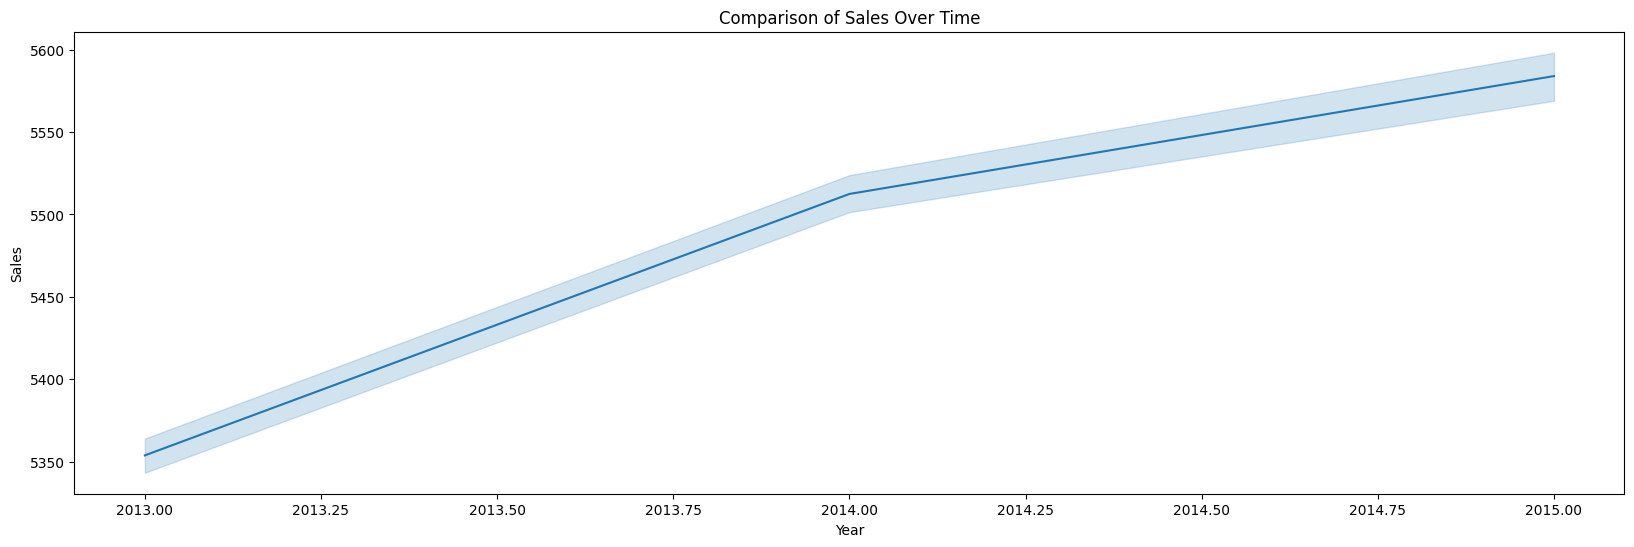

In [37]:
selected_features = ['Day',	'Week',	'Month', 'Year']
# Plotting violin plots for selected features
for feature in selected_features:
    visualizer.plot_line(train_df, feature, 'Sales')

The line plot provides a visual representation of sales trends over different time periods.

- The first plot shows sales trends over each day. The sales are high on the first and last days of the month. However, between day 1 and day 30, the sales are inconsistent, with periods of increase and decrease.
- The second plot shows sales trends over each week. The sales trends over each week appear to be stationary, meaning that the average sales do not seem to change significantly over time.
- The third plot shows sales trends over each month. The sales are higher in the 7th and 12th months, while there is a smaller sales during the 5th and 10th months.
- The fourth plot shows sales trends over each year. The sales increase year by year, indicating a positive trend over time.
Overall, the line plot provides valuable insights into sales trends over different time periods, allowing us to identify patterns and make informed decisions.

## Time Series Analysis with Prophet

Modeling Approach:

- Feature Engineering: Leveraged Prophet’s ability to handle seasonality and holiday effects directly.
- Model Training: Trained the Prophet model on the sales data.
- Evaluation: Evaluated model performance and compared it with XGBoost

Technical Implementation:

- Used Prophet’s built-in capabilities to model trends, weekly and yearly seasonality.
- Included holidays in the model to account for special events affecting sales.

In [39]:
# Function to create features from Prophet model
def create_prophet_features(df, date_col):
    try: 
        print("Creating Prophet features")
        df_prophet = df[[date_col, 'Sales']].rename(columns={date_col: 'ds', 'Sales': 'y'})
        return df_prophet
    except Exception as e:
        print(f"Error {e}")

In [40]:
prophet_df = create_prophet_features(train_df, "Date")
prophet_df.head()

Creating Prophet features


,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [ ]:
def create_prophet_model(df):
    print("Create model")
    try: 
        model = Prophet(interval_width=0.95)
        model.fit(df)
        future = model.make_future_dataframe(periods=365)
        forecast = model.predict(future)
        return model, forecast
    except Exception as e:
        print("Error on creating model {e}")

In [ ]:
model, forecast = create_prophet_model(prophet_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting. These are:

- __ds__: the datestamp of the forecasted value
- __yhat__: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- __yhat_lower__: the lower bound of our forecasts
- __yhat_upper__: the upper bound of our forecasts

## Time Series Analysis with XGBoost
Modeling Approach:

- Feature Engineering: Included additional features such as lagged sales values and rolling averages.
- Model Training: Used the XGBoost regressor to model the sales data.
- Evaluation: Evaluated model performance using metrics such as Mean Absolute Error (MAE).

Technical Implementation:

- Utilized sklearn pipelines for preprocessing, including scaling and encoding.
- Implemented cross-validation to tune hyperparameters and validate the model.

In [41]:
# Preprocessing pipeline
def create_preprocessing_pipeline(numeric_features, categorical_features):
    print("Creating preprocessing pipeline")
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor

In [ ]:
# Train and evaluate the model
def train_evaluate_model(df, target_column):

    # Define features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Define numeric and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)
    
    # Preprocess the features
   
    X_preprocessed = preprocessor.fit_transform(X)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
    
    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train)
    dtest_reg = xgb.DMatrix(X_test, y_test)
    
    # Define hyperparameters
    params = {"objective": "reg:squarederror", "tree_method": "hist"}
    n = 5000

    evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
    
     # Train XGBoost model
   
    model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=50,
    early_stopping_rounds=50)
    
    # Make predictions
   
    y_pred = model.predict(dtest_reg)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Root_Mean Squared Error: {rmse}')
    
    return model, y_pred, y_test, X

Root_Mean Squared Error: 689.7315122022644

### Model Performance
- XGBoost: Demonstrated strong performance with detailed feature engineering and hyperparameter tuning.
- Prophet: Provided interpretable results with clear indications of trend and seasonality components.

### Feature Importance
- Analyzed feature importance from the XGBoost model, highlighting key drivers of sales.
- Interpreted the seasonal and trend components from the Prophet model to understand underlying patterns.

### Final Recommendations
Suggested combining insights from both models for a more comprehensive forecasting strategy.
Recommended ongoing model retraining and validation as new data becomes available to maintain accuracy.

## Conclusions
In conclusion, this exploratory data analysis has provided valuable insights into tthe Rossmann Store Sales dataset. Through various visualizations and statistical analyses, I have identified key trends and patterns that offer a deeper understanding of the data, the following conclusions can be drawn:

- Promotions have a significant impact on sales and customer behavior. Stores with promotions had higher sales and more customers compared to stores without promotions.
- Stores that are open on all weekdays tend to have higher sales on weekends compared to stores that are closed on weekends.
- The opening or reopening of new competitors near a store can have a negative impact on sales and customer behavior. Stores that had NA as competitor distance but later on had values for competitor distance showed a decrease in sales and customers after the opening or reopening of new competitors.
- Sales trends vary over different time periods. Sales are high on the first and last days of the month, but there is inconsistency between day 1 and day 30. Sales trends over each week appear to be stationary, while sales trends over each month show higher sales in the 7th and 12th months and lower sales in the 5th and 10th months. Sales trends over each year show a positive trend, with sales increasing year by year.
- Seasonal holidays, such as Easter and Christmas, have a significant impact on sales. Stores with seasonal holidays had higher sales compared to stores without seasonal holidays.

## Limitations:

Limitations of the EDA:
- The dataset does not include data on other factors that could affect sales, such as weather conditions, economic indicators, or demographic information.
- The dataset does not include data on the quality or price of products sold in each store, which could affect sales and customer behavior.
- The dataset does not include data on the marketing or advertising efforts of each store, which could also affect sales and customer behavior.
- The dataset does not include data on the satisfaction or loyalty of customers, which could be an important factor in determining sales trends.

These limitations should be considered when interpreting the results of the analysis and when making decisions based on the findings. Further analysis could benefit from including data from all relevant sources for a more comprehensive exploration.

# Reference
[Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)

[Matplotlib Documentation](https://matplotlib.org/stable/tutorials/index.html)

[Seaborn Documentation](https://seaborn.pydata.org/tutorial.html)

[Exploratory Data Analysis](https://www.epa.gov/caddis/exploratory-data-analysis)